# 咽部分类

## 模块导入

In [1]:
import os
import sys
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

import shutil
import random
import glob
import pandas as pd
import cv2
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import MobileNetV2, MobileNet
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.optimizers import SGD,Adam
import tensorflow as tf

# 添加路径，以能正常导入mbsh、trainer
sys.path.insert(0, r"..\Lib\trainer")

from mbsh.core.images import fetch_all_files, read_img_file, resize_image,save_img_file

from mbsh import create_app
from mbsh.core.models import SmallModel
from mbsh.core.images import read_to_pd,TrainArgs
from mbsh.core.plot import Plot

from trainer import Trainer

2022-06-17 08:58:11,625 - INFO - __init__.py - init_logger - 58 - ini  logger file D:\projects\Vision\Lib\logs\kernel-10c35416-e0cf-4644-9c37-1a128830444c.log


use temp dir:d:\znyx\temp


In [2]:
## 训练配置
# 样本数据根目录
# 根目录下res中按分类标签存放各类型图像
# cache目录存放训练的结果模型

root_path = r"\\192.168.0.154\数据\口咽部\大部位27分类"
""
#是否使用平衡数据做训练
use_increase = False

#训练采用的模型名称
model_name = 'resnet'

unfreeze_layers = 179

# 模型保存id
model_id = 2801

# 数据库中记录条目的name
# sm_name = '喉-上颚-咽后壁-右梨状窝-左梨状窝'
sm_name = ''

# 如果数据库还未建立相应的记录可查询一个已存在的，再自行修改sm的desc_list

# sm_desc_list =  ["喉","上颚","咽后壁","右梨状窝","左梨状窝"]
sm_desc_list =  ["不确定", "食管", "贲门", "前壁", "后壁", "大弯", "小弯侧", "前壁",  
                "后壁","小弯","大弯侧","前壁","后壁","小弯","大弯侧",  
                 "十二指肠球部", "十二指肠降部","后壁","前壁","小弯侧","前壁","后壁",  
                 "小弯","前壁","后壁","大弯","小弯侧","咽部"]

# 数据划分为验证集的比例
split_ratio = 0.15

#过程尺寸
# img_process_size = (480,480)

# 训练图像大小，默认是(224,224)
img_size = (224,224)

# img_size = (360,360)
# 训练迭代次数
epochs = 20
## 训练配置
# 训练每批次样本数
batch_size = 16

## 初始化

In [3]:
# app创建
app = create_app(os.getenv('FLASK_CONFIG') or 'default')
app.app_context().push()

2022-06-17 08:59:17,441 - INFO - __init__.py - create_app - 71 - db url =sqlite:///D:\projects\Vision\Lib\trainer\../data\production.db


In [4]:
cache_path = root_path + '/cache'
res_path = root_path + '/res'

# res数据分割后的训练和验证集目录
res_train_path = root_path + '/res_train'
res_test_path = root_path + '/res_val'

# 数据平衡后的训练和验证集目录
train_path = root_path + '/train'
test_path = root_path + '/test'
cache_path
# 图片预测错误存放目录
pred_err_path = root_path + '/pred_err_resnet50'

# trainer创建

# 从数据库获取model信息，如果数据库还未建立相应的记录可查询一个已存在的，再自行修改sm的desc_list
# sm = SmallModel.query.get(sm_name)

sm = SmallModel(sm_name)
sm.desc_list = sm_desc_list
trainer = Trainer(sm)
trainer.img_size = img_size
trainer.target_fold = root_path

# 类型个数
types_num = len(trainer.desc_list)

desc_list = [str(x) + '-' + trainer.desc_list[x] for x in range(0,types_num)]
print(desc_list)

['0-不确定', '1-食管', '2-贲门', '3-前壁', '4-后壁', '5-大弯', '6-小弯侧', '7-前壁', '8-后壁', '9-小弯', '10-大弯侧', '11-前壁', '12-后壁', '13-小弯', '14-大弯侧', '15-十二指肠球部', '16-十二指肠降部', '17-后壁', '18-前壁', '19-小弯侧', '20-前壁', '21-后壁', '22-小弯', '23-前壁', '24-后壁', '25-大弯', '26-小弯侧', '27-咽部']


## ResNet推理

In [ ]:
K.set_learning_phase(0)
model = trainer.load_model(model_id)
# 加载训练中的最优模型
use_increase = False
# 显示预测准确度、混淆矩阵，保持混淆矩阵图到root_path
acc, y_pred, y_true, file_test,_ = trainer.predict_data([r"\\192.168.0.154\数据\口咽部\大部位27分类\res_test"], model = model)

path = Plot.show_matrix(y_pred, y_true, types_num, root_path, fig_size=10)
plt.show()
print(desc_list)

## 阔哥ResNet50模型

D:\Anaconda3\lib\site-packages\keras\backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
2022-06-17 08:59:30,338 - DEBUG - attrs.py - __getitem__ - 77 - Creating converter from 3 to 5
2022-06-17 08:59:31,554 - INFO - trainer.py - load_model - 545 - load weights 28011
2022-06-17 08:59:31,586 - DEBUG - images.py - sort_by_file_name - 354 - sort_by_file_name dirs=['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27']


find 28 from \\192.168.0.154\数据\口咽部\大部位27分类\res_test2
error img \\192.168.0.154\数据\口咽部\大部位27分类\res_test2/00/Thumbs.db
error img \\192.168.0.154\数据\口咽部\大部位27分类\res_test2/15/Thumbs.db
error img \\192.168.0.154\数据\口咽部\大部位27分类\res_test2/16/Thumbs.db
error img \\192.168.0.154\数据\口咽部\大部位27分类\res_test2/26/Thumbs.db
error img \\192.168.0.154\数据\口咽部\大部位27分类\res_test2/27/Thumbs.db
load data from fold finished ,count=11820
370/370 [==============================] - 26s 55ms/step


2022-06-17 09:01:34,368 - DEBUG - font_manager.py - _findfont_cached - 1329 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2022-06-17 09:01:34,370 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:34,371 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-06-17 09:01:34,372 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Obli

2022-06-17 09:01:34,389 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-06-17 09:01:34,390 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:34,391 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:34,391 - DEBUG - font_manager.p

2022-06-17 09:01:34,409 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\malgun.ttf', name='Malgun Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:34,409 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\simfang.ttf', name='FangSong', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:34,410 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\NirmalaB.ttf', name='Nirmala UI', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:34,411 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\georgiai.ttf', name='Georgia', style='italic', variant='normal', weight=400, stretch='normal', size='scal

2022-06-17 09:01:34,433 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\simhei.ttf', name='SimHei', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
2022-06-17 09:01:34,434 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Dengl.ttf', name='DengXian', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
2022-06-17 09:01:34,436 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\consolab.ttf', name='Consolas', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:34,437 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\mingliub.ttc', name='MingLiU-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')

cast-512ms, fold: ['\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2'] ,accurracy:89


2022-06-17 09:01:34,674 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SIMLI.TTF', name='LiSu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:34,675 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SitkaI.ttc', name='Sitka Small', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-06-17 09:01:34,676 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\consolab.ttf', name='Consolas', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:34,677 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguibli.ttf', name='Segoe UI', style='italic', variant='normal', weight=900, stretch='normal', size='scalable')) =

2022-06-17 09:01:34,698 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOOKOSI.TTF', name='Bookman Old Style', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
2022-06-17 09:01:34,698 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\STKAITI.TTF', name='STKaiti', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:34,699 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\phagspab.ttf', name='Microsoft PhagsPa', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:34,700 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoescb.ttf', name='Segoe Script', style='normal', variant='normal', weight=700, stretch='no

2022-06-17 09:01:34,719 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\palab.ttf', name='Palatino Linotype', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:34,720 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\MTEXTRA.TTF', name='MT Extra', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:34,721 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\phagspa.ttf', name='Microsoft PhagsPa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:34,721 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\lucon.ttf', name='Lucida Console', style='normal', variant='normal', weight=400, stretch='normal

2022-06-17 09:01:34,741 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GARABD.TTF', name='Garamond', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:34,742 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Sitka.ttc', name='Sitka Small', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:34,743 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALNI.TTF', name='Arial', style='italic', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
2022-06-17 09:01:34,743 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segmdl2.ttf', name='Segoe MDL2 Assets', style='normal', variant='normal', weight=400, stretch='normal', size='sc

2022-06-17 09:01:34,764 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibrili.ttf', name='Calibri', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
2022-06-17 09:01:34,764 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\georgia.ttf', name='Georgia', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:34,765 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msjhl.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=290, stretch='normal', size='scalable')) = 10.1545
2022-06-17 09:01:34,766 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\simsun.ttc', name='SimSun', style='normal', variant='normal', weight=400, stretch='normal', size='scal

2022-06-17 09:01:34,786 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\constani.ttf', name='Constantia', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-06-17 09:01:34,787 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\framdit.ttf', name='Franklin Gothic Medium', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-06-17 09:01:34,787 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\malgun.ttf', name='Malgun Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:34,788 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\wingding.ttf', name='Wingdings', style='normal', variant='normal', weight=400, stretch='norm

2022-06-17 09:01:34,811 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\BKANT.TTF', name='Book Antiqua', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:34,811 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuib.ttf', name='Segoe UI', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:34,812 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeprb.ttf', name='Segoe Print', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:34,813 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguisym.ttf', name='Segoe UI Symbol', style='normal', variant='normal', weight=400, stretch='normal', s

2022-06-17 09:01:34,833 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\holomdl2.ttf', name='HoloLens MDL2 Assets', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:34,833 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\corbel.ttf', name='Corbel', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:34,834 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbelli.ttf', name='Corbel', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
2022-06-17 09:01:34,835 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\micross.ttf', name='Microsoft Sans Serif', style='normal', variant='normal', weight=400, stretch='norma

2022-06-17 09:01:34,854 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALN.TTF', name='Arial', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
2022-06-17 09:01:34,855 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\corbelli.ttf', name='Corbel', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
2022-06-17 09:01:34,856 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\comici.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-06-17 09:01:34,856 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\STFANGSO.TTF', name='STFangsong', style='normal', variant='normal', weight=400, stretch='normal', size='scalab

2022-06-17 09:01:34,876 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\himalaya.ttf', name='Microsoft Himalaya', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:34,876 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\impact.ttf', name='Impact', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:34,877 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\DUBAI-LIGHT.TTF', name='Dubai', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
2022-06-17 09:01:34,878 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoeuii.ttf', name='Segoe UI', style='italic', variant='normal', weight=400, stretch='normal', size='s

2022-06-17 09:01:34,897 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\palab.ttf', name='Palatino Linotype', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:34,898 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\gadugib.ttf', name='Gadugi', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:34,899 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibri.ttf', name='Calibri', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:34,899 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ZWAdobeF.TTF', name='ZWAdobeF', style='normal', variant='normal', weight=400, stretch='normal', size='scala

2022-06-17 09:01:35,094 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:35,094 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,095 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,096 - DEBUG - font_manager.py - _findfont_cached - 1341 

2022-06-17 09:01:35,114 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibrii.ttf', name='Calibri', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-06-17 09:01:35,114 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\micross.ttf', name='Microsoft Sans Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,115 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\simsunb.ttf', name='SimSun-ExtB', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,116 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\msjhbd.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=700, stretch='nor

Confusion matrix, without normalization


2022-06-17 09:01:35,133 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibriz.ttf', name='Calibri', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-06-17 09:01:35,134 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msgothic.ttc', name='MS Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,134 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\wingding.ttf', name='Wingdings', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,135 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GARABD.TTF', name='Garamond', style='normal', variant='normal', weight=700, stretch='normal', size='scalable

2022-06-17 09:01:35,155 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothM.ttc', name='Yu Gothic', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
2022-06-17 09:01:35,155 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\comicbd.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:35,156 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\cambriab.ttf', name='Cambria', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:35,157 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ANTQUABI.TTF', name='Book Antiqua', style='italic', variant='normal', weight=700, stretch='normal', size

2022-06-17 09:01:35,176 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\MTCORSVA.TTF', name='Monotype Corsiva', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,177 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Candaraz.ttf', name='Candara', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-06-17 09:01:35,178 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\constan.ttf', name='Constantia', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,178 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\comic.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=400, stretch='normal', siz

2022-06-17 09:01:35,198 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\pala.ttf', name='Palatino Linotype', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,198 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\georgia.ttf', name='Georgia', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,199 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguisb.ttf', name='Segoe UI', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
2022-06-17 09:01:35,200 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ariali.ttf', name='Arial', style='italic', variant='normal', weight=400, stretch='normal', size='scalable'))

2022-06-17 09:01:35,219 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguili.ttf', name='Segoe UI', style='italic', variant='normal', weight=300, stretch='normal', size='scalable')) = 11.145
2022-06-17 09:01:35,220 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\palai.ttf', name='Palatino Linotype', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-06-17 09:01:35,221 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALNBI.TTF', name='Arial', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 11.535
2022-06-17 09:01:35,221 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\DUBAI-MEDIUM.TTF', name='Dubai', style='normal', variant='normal', weight=500, stretch='normal', size='

2022-06-17 09:01:35,241 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\impact.ttf', name='Impact', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,242 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\STSONG.TTF', name='STSong', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,242 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeuiz.ttf', name='Segoe UI', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-06-17 09:01:35,243 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\mvboli.ttf', name='MV Boli', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.0

2022-06-17 09:01:35,262 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\cour.ttf', name='Courier New', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,263 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Candara.ttf', name='Candara', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,264 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibrib.ttf', name='Calibri', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:35,264 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ZWAdobeF.TTF', name='ZWAdobeF', style='normal', variant='normal', weight=400, stretch='normal', size='scalable'))

2022-06-17 09:01:35,284 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\constanb.ttf', name='Constantia', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:35,285 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\constanz.ttf', name='Constantia', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-06-17 09:01:35,286 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\consolai.ttf', name='Consolas', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-06-17 09:01:35,286 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Dengl.ttf', name='DengXian', style='normal', variant='normal', weight=300, stretch='normal', size='scala

2022-06-17 09:01:35,307 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\constan.ttf', name='Constantia', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,307 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\LeelawUI.ttf', name='Leelawadee UI', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,308 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\georgiab.ttf', name='Georgia', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:35,309 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoescb.ttf', name='Segoe Script', style='normal', variant='normal', weight=700, stretch='normal', size

2022-06-17 09:01:35,329 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\REFSPCL.TTF', name='MS Reference Specialty', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,329 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SitkaZ.ttc', name='Sitka Small', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-06-17 09:01:35,330 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\WINGDNG2.TTF', name='Wingdings 2', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,331 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\STZHONGS.TTF', name='STZhongsong', style='normal', variant='normal', weight=400, stretch='no

2022-06-17 09:01:35,350 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\timesbi.ttf', name='Times New Roman', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-06-17 09:01:35,351 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\malgunbd.ttf', name='Malgun Gothic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:35,352 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOTHIC.TTF', name='Century Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,352 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\STCAIYUN.TTF', name='STCaiyun', style='normal', variant='normal', weight=400, stretch='normal

2022-06-17 09:01:35,402 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-06-17 09:01:35,403 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:35,404 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmr10.ttf', name='cmr10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,404 - DEBUG - font_manager.py - _findfont_cached - 134

2022-06-17 09:01:35,420 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,421 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,422 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='D:\\Anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:35,422 - DEBUG - font_manager.py - _findfont_cached 

2022-06-17 09:01:35,441 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguiemj.ttf', name='Segoe UI Emoji', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,442 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\javatext.ttf', name='Javanese Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,442 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdanaz.ttf', name='Verdana', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-06-17 09:01:35,443 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguihis.ttf', name='Segoe UI Historic', style='normal', variant='normal', weight=400, stretch='nor

2022-06-17 09:01:35,464 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\STHUPO.TTF', name='STHupo', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,464 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\segoesc.ttf', name='Segoe Script', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,465 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GOTHICI.TTF', name='Century Gothic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-06-17 09:01:35,466 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\TT0246M_.TTF', name='Square721 BT', style='normal', variant='normal', weight=400, stretch='normal', size='

2022-06-17 09:01:35,502 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\calibriz.ttf', name='Calibri', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-06-17 09:01:35,502 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\arial.ttf', name='Arial', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,503 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\DUBAI-LIGHT.TTF', name='Dubai', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
2022-06-17 09:01:35,504 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\msjhbd.ttc', name='Microsoft JhengHei', style='normal', variant='normal', weight=700, stretch='normal', size='scala

2022-06-17 09:01:35,523 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\ARIALNBI.TTF', name='Arial', style='italic', variant='normal', weight=700, stretch='condensed', size='scalable')) = 11.535
2022-06-17 09:01:35,524 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\timesi.ttf', name='Times New Roman', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-06-17 09:01:35,525 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ntailu.ttf', name='Microsoft New Tai Lue', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,525 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\verdana.ttf', name='Verdana', style='normal', variant='normal', weight=400, stretch='normal',

2022-06-17 09:01:35,546 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\Nirmala.ttf', name='Nirmala UI', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,547 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Candaral.ttf', name='Candara', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,547 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\mmrtext.ttf', name='Myanmar Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,548 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\STXIHEI.TTF', name='STXihei', style='normal', variant='normal', weight=400, stretch='normal', size='scalabl

2022-06-17 09:01:35,571 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\SIMYOU.TTF', name='YouYuan', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,572 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\mmrtext.ttf', name='Myanmar Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,572 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\corbelz.ttf', name='Corbel', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-06-17 09:01:35,573 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ebrimabd.ttf', name='Ebrima', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) 

2022-06-17 09:01:35,594 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Program Files (x86)\\Adobe\\Acrobat DC\\Resource\\Font\\AdobeDevanagari-BoldItalic.otf', name='Adobe Devanagari', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2022-06-17 09:01:35,594 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\segoeui.ttf', name='Segoe UI', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,595 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\GOTHICB.TTF', name='Century Gothic', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:35,596 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\taileb.ttf', name='Microsoft Tai Le', 

2022-06-17 09:01:35,615 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\MTCORSVA.TTF', name='Monotype Corsiva', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,615 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\STLITI.TTF', name='STLiti', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,616 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ARIALNB.TTF', name='Arial', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
2022-06-17 09:01:35,617 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\comicz.ttf', name='Comic Sans MS', style='italic', variant='normal', weight=700, stretch='normal', size='s

2022-06-17 09:01:35,636 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\YuGothR.ttc', name='Yu Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,637 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\timesbd.ttf', name='Times New Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:35,637 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\trebucbd.ttf', name='Trebuchet MS', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:35,638 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\constanz.ttf', name='Constantia', style='italic', variant='normal', weight=700, stretch='normal', 

2022-06-17 09:01:35,658 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\STSONG.TTF', name='STSong', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,659 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\Dengb.ttf', name='DengXian', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:35,660 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\framd.ttf', name='Franklin Gothic Medium', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,660 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguisli.ttf', name='Segoe UI', style='italic', variant='normal', weight=350, stretch='normal', size='sca

2022-06-17 09:01:35,680 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\comicbd.ttf', name='Comic Sans MS', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2022-06-17 09:01:35,681 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\NirmalaS.ttf', name='Nirmala UI', style='normal', variant='normal', weight=350, stretch='normal', size='scalable')) = 10.0975
2022-06-17 09:01:35,681 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\seguisli.ttf', name='Segoe UI', style='italic', variant='normal', weight=350, stretch='normal', size='scalable')) = 11.0975
2022-06-17 09:01:35,682 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\malgunbd.ttf', name='Malgun Gothic', style='normal', variant='normal', weight=700, stretch='normal'

2022-06-17 09:01:35,702 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\bahnschrift.ttf', name='Bahnschrift', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2022-06-17 09:01:35,702 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\calibrii.ttf', name='Calibri', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2022-06-17 09:01:35,703 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\seguibl.ttf', name='Segoe UI', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
2022-06-17 09:01:35,703 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(FontEntry(fname='C:\\WINDOWS\\Fonts\\tahomabd.ttf', name='Tahoma', style='normal', variant='normal', weight=700, stretch='normal', size='scala

[[133   7  25   4   1   0   0  10   1   1   0   0   3   1   0   0   1   0
    0   2   0   0   0   0   0   1   0  18]
 [  0 511  35   0   1   0   0   1   0   1   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   1]
 [  0   5 492   0   1   0   1   0   0   0   0   0   0   0   0   0   1   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   1 486   7   4   2   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  48 357   1   1   0   0   0   0   0   0   0   0   0   0   0
    0   1   0   0   0   0   0   0   0   0]
 [  0   0   0  41   1 445   8   2   0   1   0   2   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   6  24  19 301   1   0   0   0   0   1   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   0   1   0   1 474  19   2   0   1   1   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1   4 495   0   0   0   0   0   0   

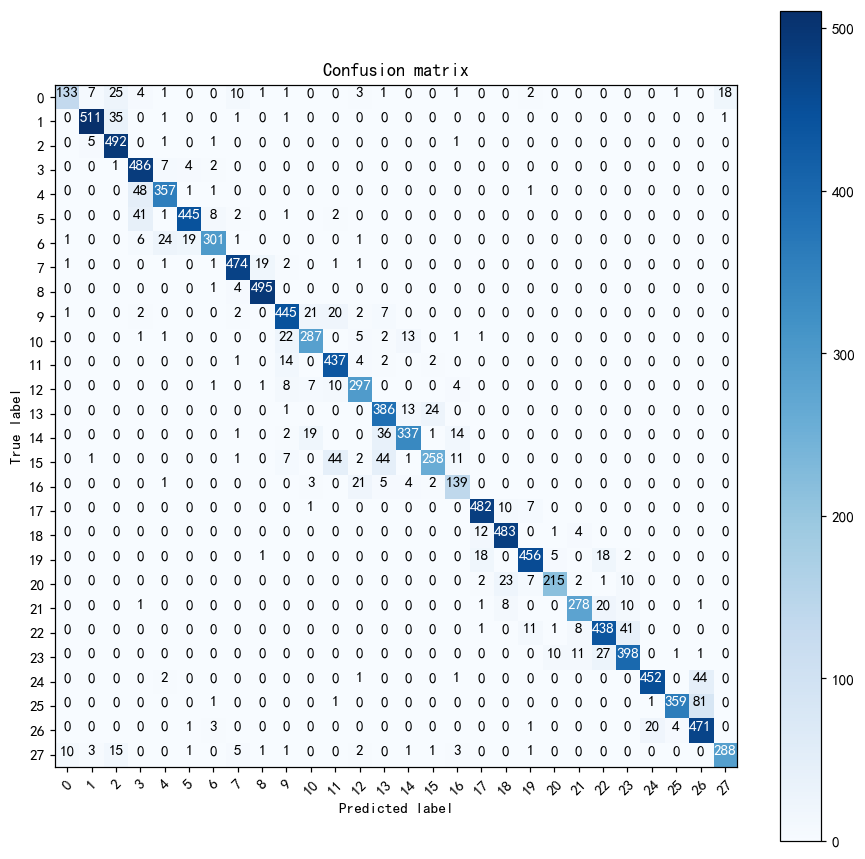

['0-不确定', '1-食管', '2-贲门', '3-前壁', '4-后壁', '5-大弯', '6-小弯侧', '7-前壁', '8-后壁', '9-小弯', '10-大弯侧', '11-前壁', '12-后壁', '13-小弯', '14-大弯侧', '15-十二指肠球部', '16-十二指肠降部', '17-后壁', '18-前壁', '19-小弯侧', '20-前壁', '21-后壁', '22-小弯', '23-前壁', '24-后壁', '25-大弯', '26-小弯侧', '27-咽部']


In [5]:
K.set_learning_phase(0)
model_id = 28011
model = trainer.load_model(model_id)
# 加载训练中的最优模型
use_increase = False
# 显示预测准确度、混淆矩阵，保持混淆矩阵图到root_path
acc, y_pred, y_true, file_test,_ = trainer.predict_data([r"\\192.168.0.154\数据\口咽部\大部位27分类\res_test2"], model = model)

path = Plot.show_matrix(y_pred, y_true, types_num, root_path, fig_size=10)
plt.show()
print(desc_list)

## EfficientNet推理

C:\ProgramData\Anaconda3\lib\site-packages\keras\backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
2022-06-14 08:32:45,834 - DEBUG - attrs.py - __getitem__ - 77 - Creating converter from 3 to 5
2022-06-14 08:32:47,044 - INFO - trainer.py - load_model - 545 - load weights 201
2022-06-14 08:32:47,048 - DEBUG - images.py - sort_by_file_name - 354 - sort_by_file_name dirs=['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27']


find 28 from \\192.168.0.154\数据\口咽部\大部位27分类\res_test2
error img \\192.168.0.154\数据\口咽部\大部位27分类\res_test2/15/Thumbs.db
error img \\192.168.0.154\数据\口咽部\大部位27分类\res_test2/16/Thumbs.db
error img \\192.168.0.154\数据\口咽部\大部位27分类\res_test2/26/Thumbs.db
error img \\192.168.0.154\数据\口咽部\大部位27分类\res_test2/27/Thumbs.db
load data from fold finished ,count=11550
361/361 [==============================] - 44s 106ms/step
cast88ms, fold: ['\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test2'] ,accurracy:86


2022-06-14 08:34:54,473 - DEBUG - colorbar.py - _get_ticker_locator_formatter - 620 - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001561DDDA4C0>
2022-06-14 08:34:54,474 - DEBUG - colorbar.py - update_ticks - 665 - Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001561DDDA4C0> on colorbar
2022-06-14 08:34:54,474 - DEBUG - colorbar.py - _add_solids_pcolormesh - 794 - Setting pcolormesh


Confusion matrix, without normalization


2022-06-14 08:34:54,650 - DEBUG - font_manager.py - _findfont_cached - 1329 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2022-06-14 08:34:54,651 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 10.335
2022-06-14 08:34:54,651 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
2022-06-14 08:34:54,652 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 11.05
2022-06-14 08:34:54,652 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
2022-06-14 08:34:54,653 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'cmr10' (cmr10.ttf) normal no

2022-06-14 08:34:54,678 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Tahoma' (tahoma.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:54,679 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Sylfaen' (sylfaen.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:54,679 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'STHupo' (STHUPO.TTF) normal normal 400 normal>) = 10.05
2022-06-14 08:34:54,679 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Calibri' (calibrii.ttf) italic normal 400 normal>) = 11.05
2022-06-14 08:34:54,680 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Microsoft Sans Serif' (micross.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:54,681 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'SimSun-ExtB' (simsunb.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:54,681 - DEBUG 

2022-06-14 08:34:54,706 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Trebuchet MS' (trebucit.ttf) italic normal 400 normal>) = 11.05
2022-06-14 08:34:54,706 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Ebrima' (ebrima.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:54,707 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Trebuchet MS' (trebucbd.ttf) normal normal 700 normal>) = 10.335
2022-06-14 08:34:54,707 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe UI' (seguibli.ttf) italic normal 900 normal>) = 11.525
2022-06-14 08:34:54,708 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Century Gothic' (GOTHICB.TTF) normal normal 700 normal>) = 10.335
2022-06-14 08:34:54,708 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'LiSu' (SIMLI.TTF) normal normal 400 normal>) = 10.05
2022-06-14 08:34:54,709 - DEB

2022-06-14 08:34:54,944 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Malgun Gothic' (malgunsl.ttf) normal normal 300 normal>) = 10.145
2022-06-14 08:34:54,944 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Microsoft New Tai Lue' (ntailu.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:54,945 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Yu Gothic' (YuGothM.ttc) normal normal 500 normal>) = 10.145
2022-06-14 08:34:54,946 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Adobe Devanagari' (AdobeDevanagari-Bold.otf) normal normal 700 normal>) = 10.335
2022-06-14 08:34:54,946 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Arial' (ARIALNB.TTF) normal normal 700 condensed>) = 10.535
2022-06-14 08:34:54,947 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Microsoft YaHei' (msyhbd.ttc) normal normal 700 normal>

2022-06-14 08:34:54,972 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Lucida Console' (lucon.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:54,972 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Candara' (Candarai.ttf) italic normal 400 normal>) = 11.05
2022-06-14 08:34:54,973 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Garamond' (GARABD.TTF) normal normal 700 normal>) = 10.335
2022-06-14 08:34:54,973 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Sitka Small' (Sitka.ttc) normal normal 400 normal>) = 10.05
2022-06-14 08:34:54,974 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Arial' (ARIALNI.TTF) italic normal 400 condensed>) = 11.25
2022-06-14 08:34:54,974 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe MDL2 Assets' (segmdl2.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:54,975 - 

2022-06-14 08:34:55,000 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Yu Gothic' (YuGothL.ttc) normal normal 300 normal>) = 10.145
2022-06-14 08:34:55,000 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Sitka Small' (SitkaB.ttc) normal normal 700 normal>) = 10.335
2022-06-14 08:34:55,001 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Wingdings 2' (WINGDNG2.TTF) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,001 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Courier New' (courbi.ttf) italic normal 700 normal>) = 11.335
2022-06-14 08:34:55,002 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Book Antiqua' (BKANT.TTF) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,003 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Adobe Devanagari' (AdobeDevanagari-BoldItalic.otf) italic normal 700 normal>) = 11.33

2022-06-14 08:34:55,027 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe UI' (segoeuib.ttf) normal normal 700 normal>) = 10.335
2022-06-14 08:34:55,028 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe Print' (segoeprb.ttf) normal normal 700 normal>) = 10.335
2022-06-14 08:34:55,028 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe UI Symbol' (seguisym.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,029 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe UI' (seguili.ttf) italic normal 300 normal>) = 11.145
2022-06-14 08:34:55,029 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Courier New' (couri.ttf) italic normal 400 normal>) = 11.05
2022-06-14 08:34:55,030 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe UI Emoji' (seguiemj.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34

2022-06-14 08:34:55,059 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'FZYaoTi' (FZYTK.TTF) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,059 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'STSong' (STSONG.TTF) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,060 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'DengXian' (Dengb.ttf) normal normal 700 normal>) = 10.335
2022-06-14 08:34:55,061 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Franklin Gothic Medium' (framd.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,061 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe UI' (seguisli.ttf) italic normal 350 normal>) = 11.0975
2022-06-14 08:34:55,062 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Dubai' (DUBAI-REGULAR.TTF) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,062 - DEB

2022-06-14 08:34:55,087 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Dubai' (DUBAI-BOLD.TTF) normal normal 700 normal>) = 10.335
2022-06-14 08:34:55,087 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Palatino Linotype' (pala.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,088 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Consolas' (consola.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,089 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Times New Roman' (timesbi.ttf) italic normal 700 normal>) = 11.335
2022-06-14 08:34:55,089 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Malgun Gothic' (malgunbd.ttf) normal normal 700 normal>) = 10.335
2022-06-14 08:34:55,090 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Century Gothic' (GOTHIC.TTF) normal normal 400 normal>) = 10.05
2022-06-14 08

2022-06-14 08:34:55,150 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335
2022-06-14 08:34:55,151 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
2022-06-14 08:34:55,151 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
2022-06-14 08:34:55,152 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,152 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
2022-06-14 08:34:55,153 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisp

2022-06-14 08:34:55,177 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Dubai' (DUBAI-REGULAR.TTF) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,177 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Candara' (Candara.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,178 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Verdana' (verdana.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,179 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Microsoft PhagsPa' (phagspab.ttf) normal normal 700 normal>) = 10.335
2022-06-14 08:34:55,179 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Microsoft YaHei' (msyh.ttc) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,180 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe Print' (segoepr.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,1

2022-06-14 08:34:55,205 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Cambria' (cambriab.ttf) normal normal 700 normal>) = 10.335
2022-06-14 08:34:55,206 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Book Antiqua' (ANTQUABI.TTF) italic normal 700 normal>) = 11.335
2022-06-14 08:34:55,206 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'SimHei' (simhei.ttf) normal normal 400 normal>) = 0.05
2022-06-14 08:34:55,207 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe UI' (segoeuil.ttf) normal normal 300 normal>) = 10.145
2022-06-14 08:34:55,207 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Arial' (ariblk.ttf) normal normal 900 normal>) = 10.525
2022-06-14 08:34:55,208 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'STXinwei' (STXINWEI.TTF) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,209 - DEBUG - fon

2022-06-14 08:34:55,234 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Microsoft JhengHei' (msjh.ttc) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,234 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Lucida Sans Unicode' (l_10646.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,235 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Nirmala UI' (NirmalaB.ttf) normal normal 700 normal>) = 10.335
2022-06-14 08:34:55,236 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Palatino Linotype' (palab.ttf) normal normal 700 normal>) = 10.335
2022-06-14 08:34:55,236 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'MT Extra' (MTEXTRA.TTF) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,237 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Microsoft PhagsPa' (phagspa.ttf) normal normal 400 normal>) = 10.05
2

2022-06-14 08:34:55,261 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Webdings' (webdings.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,262 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Times New Roman' (timesi.ttf) italic normal 400 normal>) = 11.05
2022-06-14 08:34:55,262 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Georgia' (georgiaz.ttf) italic normal 700 normal>) = 11.335
2022-06-14 08:34:55,263 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Bookman Old Style' (BOOKOSB.TTF) normal normal 600 normal>) = 10.24
2022-06-14 08:34:55,263 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Lucida Sans Unicode' (l_10646.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,264 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'FZYaoTi' (FZYTK.TTF) normal normal 400 normal>) = 10.05
2022-06-14 08:3

2022-06-14 08:34:55,290 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Constantia' (constani.ttf) italic normal 400 normal>) = 11.05
2022-06-14 08:34:55,290 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Franklin Gothic Medium' (framdit.ttf) italic normal 400 normal>) = 11.05
2022-06-14 08:34:55,291 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Malgun Gothic' (malgun.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,291 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Wingdings' (wingding.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,292 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Sitka Small' (Sitka.ttc) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,292 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Dubai' (DUBAI-MEDIUM.TTF) normal normal 500 normal>) = 10.145
2022-06-14 08

2022-06-14 08:34:55,319 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Wingdings 3' (WINGDNG3.TTF) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,319 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'STZhongsong' (STZHONGS.TTF) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,320 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Yu Gothic' (YuGothR.ttc) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,321 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Times New Roman' (timesbd.ttf) normal normal 700 normal>) = 10.335
2022-06-14 08:34:55,321 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Trebuchet MS' (trebucbd.ttf) normal normal 700 normal>) = 10.335
2022-06-14 08:34:55,322 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Constantia' (constanz.ttf) italic normal 700 normal>) = 11.335
2022-06-14 08

2022-06-14 08:34:55,347 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'STFangsong' (STFANGSO.TTF) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,348 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe UI' (segoeuisl.ttf) normal normal 350 normal>) = 10.0975
2022-06-14 08:34:55,348 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Trebuchet MS' (trebucbi.ttf) italic normal 700 normal>) = 11.335
2022-06-14 08:34:55,349 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'FZShuTi' (FZSTK.TTF) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,349 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Trebuchet MS' (trebucbi.ttf) italic normal 700 normal>) = 11.335
2022-06-14 08:34:55,350 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'MS Reference Specialty' (REFSPCL.TTF) normal normal 400 normal>) = 10.05
2022-06-14

2022-06-14 08:34:55,375 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Bahnschrift' (bahnschrift.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,375 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Calibri' (calibrii.ttf) italic normal 400 normal>) = 11.05
2022-06-14 08:34:55,376 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe UI' (seguibl.ttf) normal normal 900 normal>) = 10.525
2022-06-14 08:34:55,376 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Tahoma' (tahomabd.ttf) normal normal 700 normal>) = 10.335
2022-06-14 08:34:55,377 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Sitka Small' (SitkaZ.ttc) italic normal 700 normal>) = 11.335
2022-06-14 08:34:55,377 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Times New Roman' (times.ttf) normal normal 400 normal>) = 10.05
2022-06-14 08:34:55,378 

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  1 514  26   0   0   0   0   1   0   0   0   0   0   0   2   0   2   0
    0   0   0   0   0   0   0   0   0   4]
 [  1  16 476   0   0   0   0   0   0   0   0   0   0   0   1   0   2   0
    0   0   0   0   0   0   0   0   1   3]
 [  1   0   0 431  19  39   2   1   0   6   1   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  37 367   2   0   0   0   0   2   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  23   0 461  12   2   0   1   0   1   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   6  17  16 312   2   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  7   0   0   0   1   2  10 440  22  13   0   1   0   0   0   2   0   0
    0   0   0   0   0   0   0   0   0   2]
 [  1   0   0   1   0   1   0   2 492   1   0   0   0   0   0   

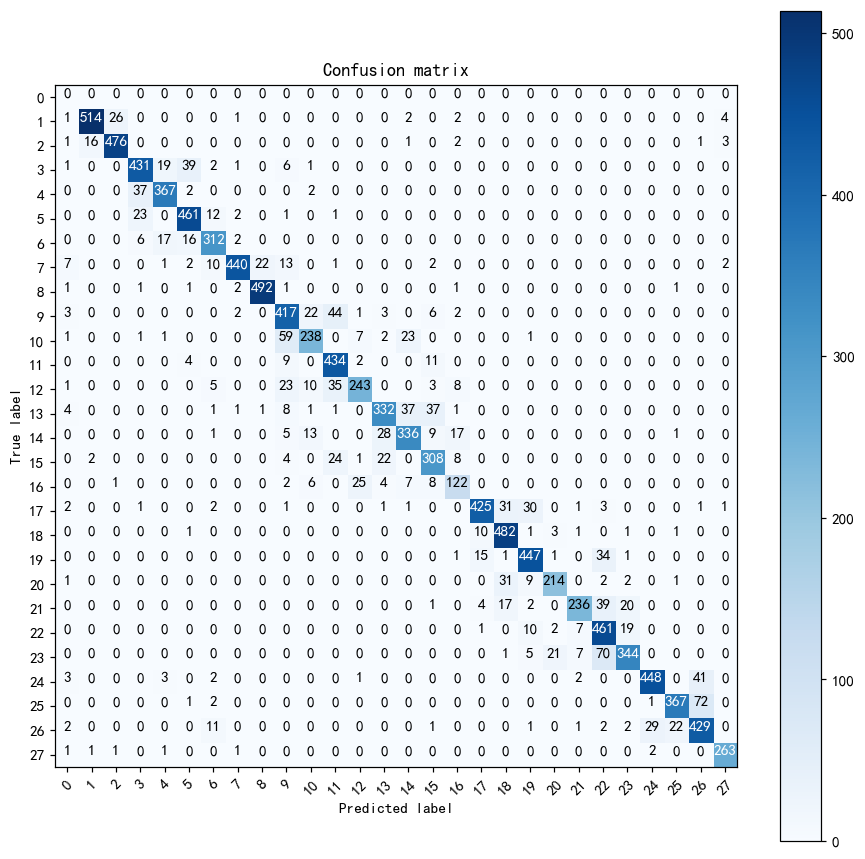

['0-不确定', '1-食管', '2-贲门', '3-前壁', '4-后壁', '5-大弯', '6-小弯侧', '7-前壁', '8-后壁', '9-小弯', '10-大弯侧', '11-前壁', '12-后壁', '13-小弯', '14-大弯侧', '15-十二指肠球部', '16-十二指肠降部', '17-后壁', '18-前壁', '19-小弯侧', '20-前壁', '21-后壁', '22-小弯', '23-前壁', '24-后壁', '25-大弯', '26-小弯侧', '27-咽部']


In [6]:
K.set_learning_phase(0)
model_id = 201
model = trainer.load_model(model_id)
# 加载训练中的最优模型
use_increase = False
# 显示预测准确度、混淆矩阵，保持混淆矩阵图到root_path
acc, y_pred, y_true, file_test,_ = trainer.predict_data([r"\\192.168.0.154\数据\口咽部\大部位27分类\res_test2"], model = model)

path = Plot.show_matrix(y_pred, y_true, types_num, root_path, fig_size=10)
plt.show()
print(desc_list)

## VGG16推理

C:\ProgramData\Anaconda3\lib\site-packages\keras\backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
2022-06-03 21:48:34,891 - DEBUG - attrs.py - __getitem__ - 77 - Creating converter from 3 to 5
2022-06-03 21:48:39,067 - INFO - trainer.py - load_model - 545 - load weights 28012
2022-06-03 21:48:39,076 - DEBUG - images.py - sort_by_file_name - 354 - sort_by_file_name dirs=['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27']


find 28 from \\192.168.0.154\数据\口咽部\大部位27分类\res_test
error img \\192.168.0.154\数据\口咽部\大部位27分类\res_test/00/Thumbs.db
error img \\192.168.0.154\数据\口咽部\大部位27分类\res_test/27/Thumbs.db
load data from fold finished ,count=7560
237/237 [==============================] - 174s 572ms/step
cast789ms, fold: ['\\\\192.168.0.154\\数据\\口咽部\\大部位27分类\\res_test'] ,accurracy:84


2022-06-03 21:52:42,098 - DEBUG - colorbar.py - _get_ticker_locator_formatter - 620 - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001FEC6399880>
2022-06-03 21:52:42,099 - DEBUG - colorbar.py - update_ticks - 665 - Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001FEC6399880> on colorbar
2022-06-03 21:52:42,099 - DEBUG - colorbar.py - _add_solids_pcolormesh - 794 - Setting pcolormesh


Confusion matrix, without normalization


2022-06-03 21:52:42,495 - DEBUG - font_manager.py - _findfont_cached - 1329 - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2022-06-03 21:52:42,496 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 10.335
2022-06-03 21:52:42,497 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
2022-06-03 21:52:42,498 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 11.05
2022-06-03 21:52:42,498 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'STIXNonUnicode' (STIXNonUniBol.ttf) normal normal 700 normal>) = 10.335
2022-06-03 21:52:42,499 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'cmr10' (cmr10.ttf) normal no

2022-06-03 21:52:42,539 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Tahoma' (tahoma.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,539 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Sylfaen' (sylfaen.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,540 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'STHupo' (STHUPO.TTF) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,540 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Calibri' (calibrii.ttf) italic normal 400 normal>) = 11.05
2022-06-03 21:52:42,541 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Microsoft Sans Serif' (micross.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,542 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'SimSun-ExtB' (simsunb.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,542 - DEBUG 

2022-06-03 21:52:42,574 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Trebuchet MS' (trebucit.ttf) italic normal 400 normal>) = 11.05
2022-06-03 21:52:42,575 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Ebrima' (ebrima.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,576 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Trebuchet MS' (trebucbd.ttf) normal normal 700 normal>) = 10.335
2022-06-03 21:52:42,576 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe UI' (seguibli.ttf) italic normal 900 normal>) = 11.525
2022-06-03 21:52:42,577 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Century Gothic' (GOTHICB.TTF) normal normal 700 normal>) = 10.335
2022-06-03 21:52:42,578 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'LiSu' (SIMLI.TTF) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,578 - DEB

2022-06-03 21:52:42,608 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Malgun Gothic' (malgunsl.ttf) normal normal 300 normal>) = 10.145
2022-06-03 21:52:42,609 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Microsoft New Tai Lue' (ntailu.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,610 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Yu Gothic' (YuGothM.ttc) normal normal 500 normal>) = 10.145
2022-06-03 21:52:42,610 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Adobe Devanagari' (AdobeDevanagari-Bold.otf) normal normal 700 normal>) = 10.335
2022-06-03 21:52:42,611 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Arial' (ARIALNB.TTF) normal normal 700 condensed>) = 10.535
2022-06-03 21:52:42,612 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Microsoft YaHei' (msyhbd.ttc) normal normal 700 normal>

2022-06-03 21:52:42,640 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Lucida Console' (lucon.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,640 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Candara' (Candarai.ttf) italic normal 400 normal>) = 11.05
2022-06-03 21:52:42,641 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Garamond' (GARABD.TTF) normal normal 700 normal>) = 10.335
2022-06-03 21:52:42,642 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Sitka Small' (Sitka.ttc) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,642 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Arial' (ARIALNI.TTF) italic normal 400 condensed>) = 11.25
2022-06-03 21:52:42,643 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe MDL2 Assets' (segmdl2.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,644 - 

2022-06-03 21:52:42,673 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Yu Gothic' (YuGothL.ttc) normal normal 300 normal>) = 10.145
2022-06-03 21:52:42,674 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Sitka Small' (SitkaB.ttc) normal normal 700 normal>) = 10.335
2022-06-03 21:52:42,675 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Wingdings 2' (WINGDNG2.TTF) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,676 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Courier New' (courbi.ttf) italic normal 700 normal>) = 11.335
2022-06-03 21:52:42,676 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Book Antiqua' (BKANT.TTF) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,677 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Adobe Devanagari' (AdobeDevanagari-BoldItalic.otf) italic normal 700 normal>) = 11.33

2022-06-03 21:52:42,706 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe UI' (segoeuib.ttf) normal normal 700 normal>) = 10.335
2022-06-03 21:52:42,707 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe Print' (segoeprb.ttf) normal normal 700 normal>) = 10.335
2022-06-03 21:52:42,708 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe UI Symbol' (seguisym.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,709 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe UI' (seguili.ttf) italic normal 300 normal>) = 11.145
2022-06-03 21:52:42,709 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Courier New' (couri.ttf) italic normal 400 normal>) = 11.05
2022-06-03 21:52:42,710 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe UI Emoji' (seguiemj.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52

2022-06-03 21:52:42,739 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'FZYaoTi' (FZYTK.TTF) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,740 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'STSong' (STSONG.TTF) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,740 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'DengXian' (Dengb.ttf) normal normal 700 normal>) = 10.335
2022-06-03 21:52:42,741 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Franklin Gothic Medium' (framd.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,741 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe UI' (seguisli.ttf) italic normal 350 normal>) = 11.0975
2022-06-03 21:52:42,742 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Dubai' (DUBAI-REGULAR.TTF) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,743 - DEB

2022-06-03 21:52:42,771 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Dubai' (DUBAI-BOLD.TTF) normal normal 700 normal>) = 10.335
2022-06-03 21:52:42,772 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Palatino Linotype' (pala.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,772 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Consolas' (consola.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,773 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Times New Roman' (timesbi.ttf) italic normal 700 normal>) = 11.335
2022-06-03 21:52:42,774 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Malgun Gothic' (malgunbd.ttf) normal normal 700 normal>) = 10.335
2022-06-03 21:52:42,774 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Century Gothic' (GOTHIC.TTF) normal normal 400 normal>) = 10.05
2022-06-03 21

2022-06-03 21:52:42,843 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335
2022-06-03 21:52:42,843 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal 700 normal>) = 10.335
2022-06-03 21:52:42,844 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
2022-06-03 21:52:42,845 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'cmex10' (cmex10.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,846 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'DejaVu Sans' (DejaVuSans-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
2022-06-03 21:52:42,846 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'DejaVu Sans Display' (DejaVuSansDisp

2022-06-03 21:52:42,876 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Dubai' (DUBAI-REGULAR.TTF) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,876 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Candara' (Candara.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,877 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Verdana' (verdana.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,878 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Microsoft PhagsPa' (phagspab.ttf) normal normal 700 normal>) = 10.335
2022-06-03 21:52:42,878 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Microsoft YaHei' (msyh.ttc) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,879 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe Print' (segoepr.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,8

2022-06-03 21:52:42,909 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Cambria' (cambriab.ttf) normal normal 700 normal>) = 10.335
2022-06-03 21:52:42,910 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Book Antiqua' (ANTQUABI.TTF) italic normal 700 normal>) = 11.335
2022-06-03 21:52:42,910 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'SimHei' (simhei.ttf) normal normal 400 normal>) = 0.05
2022-06-03 21:52:42,911 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe UI' (segoeuil.ttf) normal normal 300 normal>) = 10.145
2022-06-03 21:52:42,912 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Arial' (ariblk.ttf) normal normal 900 normal>) = 10.525
2022-06-03 21:52:42,913 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'STXinwei' (STXINWEI.TTF) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,913 - DEBUG - fon

2022-06-03 21:52:42,942 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Microsoft JhengHei' (msjh.ttc) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,943 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Lucida Sans Unicode' (l_10646.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,944 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Nirmala UI' (NirmalaB.ttf) normal normal 700 normal>) = 10.335
2022-06-03 21:52:42,945 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Palatino Linotype' (palab.ttf) normal normal 700 normal>) = 10.335
2022-06-03 21:52:42,945 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'MT Extra' (MTEXTRA.TTF) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,946 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Microsoft PhagsPa' (phagspa.ttf) normal normal 400 normal>) = 10.05
2

2022-06-03 21:52:42,974 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Webdings' (webdings.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,974 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Times New Roman' (timesi.ttf) italic normal 400 normal>) = 11.05
2022-06-03 21:52:42,975 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Georgia' (georgiaz.ttf) italic normal 700 normal>) = 11.335
2022-06-03 21:52:42,975 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Bookman Old Style' (BOOKOSB.TTF) normal normal 600 normal>) = 10.24
2022-06-03 21:52:42,976 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Lucida Sans Unicode' (l_10646.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:42,976 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'FZYaoTi' (FZYTK.TTF) normal normal 400 normal>) = 10.05
2022-06-03 21:5

2022-06-03 21:52:43,006 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Constantia' (constani.ttf) italic normal 400 normal>) = 11.05
2022-06-03 21:52:43,006 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Franklin Gothic Medium' (framdit.ttf) italic normal 400 normal>) = 11.05
2022-06-03 21:52:43,007 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Malgun Gothic' (malgun.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:43,007 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Wingdings' (wingding.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:43,008 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Sitka Small' (Sitka.ttc) normal normal 400 normal>) = 10.05
2022-06-03 21:52:43,009 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Dubai' (DUBAI-MEDIUM.TTF) normal normal 500 normal>) = 10.145
2022-06-03 21

2022-06-03 21:52:43,035 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Wingdings 3' (WINGDNG3.TTF) normal normal 400 normal>) = 10.05
2022-06-03 21:52:43,036 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'STZhongsong' (STZHONGS.TTF) normal normal 400 normal>) = 10.05
2022-06-03 21:52:43,037 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Yu Gothic' (YuGothR.ttc) normal normal 400 normal>) = 10.05
2022-06-03 21:52:43,037 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Times New Roman' (timesbd.ttf) normal normal 700 normal>) = 10.335
2022-06-03 21:52:43,038 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Trebuchet MS' (trebucbd.ttf) normal normal 700 normal>) = 10.335
2022-06-03 21:52:43,039 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Constantia' (constanz.ttf) italic normal 700 normal>) = 11.335
2022-06-03 21

2022-06-03 21:52:43,068 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'STFangsong' (STFANGSO.TTF) normal normal 400 normal>) = 10.05
2022-06-03 21:52:43,069 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe UI' (segoeuisl.ttf) normal normal 350 normal>) = 10.0975
2022-06-03 21:52:43,069 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Trebuchet MS' (trebucbi.ttf) italic normal 700 normal>) = 11.335
2022-06-03 21:52:43,070 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'FZShuTi' (FZSTK.TTF) normal normal 400 normal>) = 10.05
2022-06-03 21:52:43,070 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Trebuchet MS' (trebucbi.ttf) italic normal 700 normal>) = 11.335
2022-06-03 21:52:43,071 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'MS Reference Specialty' (REFSPCL.TTF) normal normal 400 normal>) = 10.05
2022-06-03

2022-06-03 21:52:43,099 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Bahnschrift' (bahnschrift.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:43,100 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Calibri' (calibrii.ttf) italic normal 400 normal>) = 11.05
2022-06-03 21:52:43,100 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Segoe UI' (seguibl.ttf) normal normal 900 normal>) = 10.525
2022-06-03 21:52:43,101 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Tahoma' (tahomabd.ttf) normal normal 700 normal>) = 10.335
2022-06-03 21:52:43,101 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Sitka Small' (SitkaZ.ttc) italic normal 700 normal>) = 11.335
2022-06-03 21:52:43,102 - DEBUG - font_manager.py - _findfont_cached - 1341 - findfont: score(<Font 'Times New Roman' (times.ttf) normal normal 400 normal>) = 10.05
2022-06-03 21:52:43,103 

[[135   5  20   1   1   2   0   5   0  11   0   0   9   1   0   0   1   0
    0   1   0   0   0   0   1   0   0  77]
 [  3 240  26   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0
    0   0   0   0   0   0   0   0   0   0]
 [  2   7 255   0   0   0   1   0   0   0   0   0   0   0   0   0   4   0
    0   0   0   0   0   0   0   0   0   1]
 [  2   0   0 228  14  17   2   0   0   7   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  36 227   1   3   0   0   0   1   0   1   0   0   0   0   0
    0   0   0   0   0   0   1   0   0   0]
 [  0   0   0  15   0 250   2   2   0   0   0   1   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  3   1   0   4  13  37 209   2   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   1   0]
 [  5   0   0   0   0   0   1 244  13   2   0   2   0   0   0   1   1   0
    0   0   0   0   0   0   0   0   1   0]
 [  2   0   0   1   0   0   1   5 259   0   0   0   2   0   0   

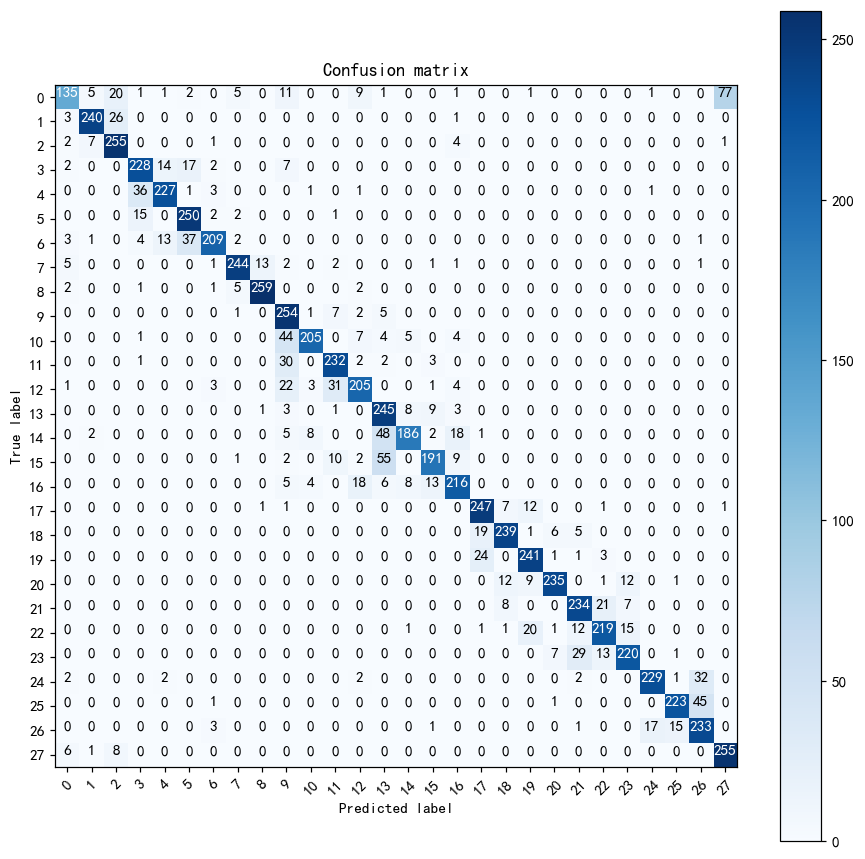

['0-不确定', '1-食管', '2-贲门', '3-前壁', '4-后壁', '5-大弯', '6-小弯侧', '7-前壁', '8-后壁', '9-小弯', '10-大弯侧', '11-前壁', '12-后壁', '13-小弯', '14-大弯侧', '15-十二指肠球部', '16-十二指肠降部', '17-后壁', '18-前壁', '19-小弯侧', '20-前壁', '21-后壁', '22-小弯', '23-前壁', '24-后壁', '25-大弯', '26-小弯侧', '27-咽部']


In [6]:
K.set_learning_phase(0)
model_id = 28012
model = trainer.load_model(model_id)
# 加载训练中的最优模型
use_increase = False
# 显示预测准确度、混淆矩阵，保持混淆矩阵图到root_path
acc, y_pred, y_true, file_test,_ = trainer.predict_data([r"\\192.168.0.154\数据\口咽部\大部位27分类\res_test"], model = model)

path = Plot.show_matrix(y_pred, y_true, types_num, root_path, fig_size=10)
plt.show()
print(desc_list)

## 硬盘加载

In [11]:
import cv2
def img_rgb2_bgr(img):
    img = img[:,:, : : -1]
    return img

# 图片生成器
train_datagen =  ImageDataGenerator(       
        width_shift_range = 0.15,
        height_shift_range = 0.15,
        shear_range = 0,
        rotation_range = 10,
        zoom_range = 0.1,
        fill_mode='constant',
        vertical_flip=False,
        horizontal_flip=False,
        preprocessing_function = img_rgb2_bgr,
    )

test_datagen =  ImageDataGenerator(
        fill_mode='constant',
        preprocessing_function = img_rgb2_bgr,
    )

# 训练数据与测试数据
cls_mode = 'binary' if types_num == 2 else 'categorical'
train_generator = train_datagen.flow_from_directory(
        res_train_path,
        target_size = img_size,
        batch_size = batch_size,
        class_mode = cls_mode)
test_generator = test_datagen.flow_from_directory(
        res_test_path,
        target_size = img_size,
        batch_size = batch_size,
        class_mode = cls_mode)

train_samples = train_generator.samples
valid_samples = test_generator.samples

Found 70552 images belonging to 28 classes.
Found 7395 images belonging to 28 classes.


In [12]:
def fit_gen(model, model_id, epochs = 5):
    class_mode = 'binary' if types_num == 2 else 'categorical'
    print("train from imgs model_id=%s ,class_mode=%s" % (model_id, class_mode))
                
    # 创建cache目录
    if not os.path.exists(cache_path):
        os.mkdir(cache_path)
    
    weight_path = cache_path + '/weights' + str(model_id) + '.hdf5'
    
    # EarlyStoppingy原型：
    # EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    early_stop = EarlyStopping(monitor='val_loss', patience = 8)
    
    # ModelCheckpoint原型：
    # ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    check_point = ModelCheckpoint(weight_path, monitor='val_loss', save_best_only=True, save_weights_only=True)
    
    # callbacks设置
    callbacks = [early_stop, check_point]
    
    
    history = model.fit_generator(
        train_generator,
        epochs = epochs,
        steps_per_epoch = train_samples // batch_size,
        validation_data = test_generator,
        validation_steps = valid_samples // batch_size,
        callbacks = callbacks)
    return history

## 训练

#### 创建模型

In [13]:
trainer.model_type = model_name
model = trainer.create_model(unfreeze_layers=unfreeze_layers )
model.summary()

create model resnet, unfreeze_layers 179


E:\Anaconda3\envs\tf\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [15]:
len(model.layers)

179

In [16]:
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

#### 训练

In [17]:
model_id

2801

In [18]:
# 训练
K.set_learning_phase(1)
history = fit_gen(model, model_id, epochs =50)
#保存
trainer.save_model(model, model_id)

train from imgs model_id=2801 ,class_mode=categorical
Epoch 1/50
4408/4409 [============================>.] - ETA: 0s - loss: 0.7575 - acc: 0.7479WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x0000021D0BDEC828>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


2022-05-28 12:20:48,653 - WARNING - tf_logging.py - warning - 125 - This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x0000021D0BDEC828>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


4409/4409 [==============================] - 859s 195ms/step - loss: 0.7575 - acc: 0.7479 - val_loss: 0.4871 - val_acc: 0.8312
Epoch 2/50
4408/4409 [============================>.] - ETA: 0s - loss: 0.4706 - acc: 0.8344WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x0000021D0BDEC828>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


2022-05-28 12:33:18,150 - WARNING - tf_logging.py - warning - 125 - This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x0000021D0BDEC828>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


4409/4409 [==============================] - 748s 170ms/step - loss: 0.4705 - acc: 0.8344 - val_loss: 0.3959 - val_acc: 0.8630
Epoch 3/50
4408/4409 [============================>.] - ETA: 0s - loss: 0.4061 - acc: 0.8556WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x0000021D0BDEC828>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


2022-05-28 12:45:33,566 - WARNING - tf_logging.py - warning - 125 - This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x0000021D0BDEC828>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


4409/4409 [==============================] - 735s 167ms/step - loss: 0.4061 - acc: 0.8557 - val_loss: 0.3760 - val_acc: 0.8662
Epoch 4/50
4408/4409 [============================>.] - ETA: 0s - loss: 0.3646 - acc: 0.8697WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x0000021D0BDEC828>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


2022-05-28 12:57:49,477 - WARNING - tf_logging.py - warning - 125 - This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x0000021D0BDEC828>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


4409/4409 [==============================] - 736s 167ms/step - loss: 0.3646 - acc: 0.8697 - val_loss: 0.3600 - val_acc: 0.8761
Epoch 5/50
4409/4409 [==============================] - 743s 169ms/step - loss: 0.3332 - acc: 0.8803 - val_loss: 0.3804 - val_acc: 0.8680
Epoch 6/50
4409/4409 [==============================] - 796s 180ms/step - loss: 0.3083 - acc: 0.8889 - val_loss: 0.3930 - val_acc: 0.8612
Epoch 7/50
4409/4409 [==============================] - 783s 178ms/step - loss: 0.2811 - acc: 0.8987 - val_loss: 0.3659 - val_acc: 0.8766
Epoch 8/50
4408/4409 [============================>.] - ETA: 0s - loss: 0.2628 - acc: 0.9041WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x0000021D0BDEC828>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow 

2022-05-28 13:48:46,584 - WARNING - tf_logging.py - warning - 125 - This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x0000021D0BDEC828>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


4409/4409 [==============================] - 735s 167ms/step - loss: 0.2628 - acc: 0.9041 - val_loss: 0.3413 - val_acc: 0.8846
Epoch 9/50
4409/4409 [==============================] - 736s 167ms/step - loss: 0.2446 - acc: 0.9113 - val_loss: 0.3542 - val_acc: 0.8862
Epoch 10/50
4409/4409 [==============================] - 744s 169ms/step - loss: 0.2310 - acc: 0.9148 - val_loss: 0.3765 - val_acc: 0.8788
Epoch 11/50
4409/4409 [==============================] - 789s 179ms/step - loss: 0.2118 - acc: 0.9218 - val_loss: 0.3800 - val_acc: 0.8780
Epoch 12/50
4408/4409 [============================>.] - ETA: 0s - loss: 0.1989 - acc: 0.9272WARNING:tensorflow:This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x0000021D0BDEC828>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFl

2022-05-28 14:39:32,422 - WARNING - tf_logging.py - warning - 125 - This model was compiled with a Keras optimizer (<tensorflow.python.keras.optimizers.SGD object at 0x0000021D0BDEC828>) but is being saved in TensorFlow format with `save_weights`. The model's weights will be saved, but unlike with TensorFlow optimizers in the TensorFlow format the optimizer's state will not be saved.

Consider using a TensorFlow optimizer from `tf.train`.


4409/4409 [==============================] - 777s 176ms/step - loss: 0.1989 - acc: 0.9272 - val_loss: 0.3386 - val_acc: 0.8879
Epoch 13/50
4409/4409 [==============================] - 751s 170ms/step - loss: 0.1845 - acc: 0.9322 - val_loss: 0.3605 - val_acc: 0.8815
Epoch 14/50
4409/4409 [==============================] - 729s 165ms/step - loss: 0.1712 - acc: 0.9374 - val_loss: 0.3470 - val_acc: 0.8903
Epoch 15/50
4409/4409 [==============================] - 734s 167ms/step - loss: 0.1582 - acc: 0.9417 - val_loss: 0.3830 - val_acc: 0.8828
Epoch 16/50
4409/4409 [==============================] - 771s 175ms/step - loss: 0.1528 - acc: 0.9439 - val_loss: 0.4140 - val_acc: 0.8792
Epoch 17/50
4409/4409 [==============================] - 776s 176ms/step - loss: 0.1400 - acc: 0.9488 - val_loss: 0.3881 - val_acc: 0.8831
Epoch 18/50
4409/4409 [==============================] - 761s 173ms/step - loss: 0.1320 - acc: 0.9528 - val_loss: 0.3966 - val_acc: 0.8845
Epoch 19/50
4409/4409 [================

2022-05-28 16:19:23,019 - INFO - trainer.py - save_model - 595 - save model success ,num=2801


In [19]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

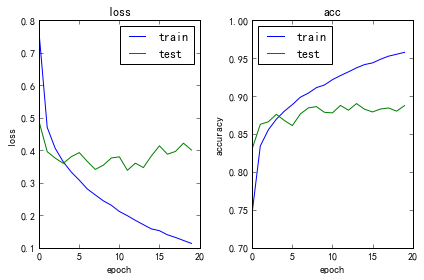

In [20]:
def show_history(history):
    fig, axes = plt.subplots(nrows=1,ncols=2)
    ax=axes[0]

    ax.plot(history['loss'])
    ax.plot(history['val_loss'])
    ax.legend(['train','test'],loc='upper right')
    ax.set_title('loss'.format(1))
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

    ax=axes[1]
    ax.plot(history['acc'])
    ax.plot(history['val_acc'])
    ax.legend(['train','test'],loc='best')
    ax.set_title('acc'.format(1))
    ax.set_xlabel('epoch')
    ax.set_ylabel('accuracy')
    fig.tight_layout()
    plt.savefig(os.path.join(root_path,"训练曲线.png"))
#     plt.savefig("训练曲线.png")
    plt.show() 
    
show_history(history.history)

#### 查看训练结果

In [13]:
def read_img(path):
    img = cv2.imdecode(np.fromfile(path, dtype=np.uint8), cv2.IMREAD_UNCHANGED) #cv2.imread(path)
#     img = cv2.resize(img, (224, 224), cv2.INTER_LINEAR)
    img = cv2.resize(img, (224, 224))
    return img

In [21]:
model_id

2801

In [22]:
model = trainer.load_model(model_id)

2022-05-28 18:46:48,472 - INFO - trainer.py - load_model - 580 - load weights 2801


In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [17]:
imgs_dir = r"D:\数据\口咽部\大部位27分类\res_test"

i=0
for file in os.listdir(imgs_dir):
    img_path = os.path.join(imgs_dir,file)
    img = read_img_file(img_path)
    img_resize = cv2.resize(img,(224,224))
    
    X = np.asarray([img_resize])
    predicitons_list = model.predict(X, verbose=0)[0]
    class_index = np.argmax(predicitons_list)
    confidence = np.max(predicitons_list)
    if class_index == 2:
        i+=1
        print(file+' 识别为咽后壁 '+' 概率为 '+str(confidence))
        print(predicitons_list)
print('识别为咽后壁总数为'+str(i))

202106241553#20210810112536202.jpg 识别为咽后壁  概率为 0.7988816
[6.8384267e-08 2.0111836e-01 7.9888159e-01 1.5652894e-11 1.7322208e-11]
识别为咽后壁总数为1


In [26]:
imgs_dir = r"E:\projects\znyx-trainer\job\口咽部\第3轮\训练集\valid_data\4"
save_dir = r"E:\projects\znyx-trainer\job\口咽部\第3轮\训练集\valid_data\左梨状窝识别成右梨状窝"

num = 0
for file in os.listdir(imgs_dir):
    img_path = os.path.join(imgs_dir,file)
    save_path = os.path.join(save_dir,file)
    img = read_img_file(img_path)
    img_resize = cv2.resize(img,(224,224))
    
    X = np.asarray([img_resize])
    predicitons_list = model.predict(X, verbose=0)[0]
    class_index = np.argmax(predicitons_list)
    confidence = np.max(predicitons_list)
    if class_index == 3:
        num+=1
        print(file+' 识别为右梨状窝 '+' 概率为 '+str(confidence))
        save_img_file(save_path,img)
print('识别为右梨状窝总数为'+str(num))

01.0000000052746.0070.1521692741_f5850.jpg 识别为右梨状窝  概率为 0.66510105
1-食管_0_c87&001_0_001_2021_04_01_10_01_361.jpg 识别为右梨状窝  概率为 0.974855
2-贲门_0_c1&001_0_001_2021_05_06_09_18_557.jpg 识别为右梨状窝  概率为 0.82600063
2-贲门_0_c15&001_0_001_2021_06_18_11_20_652.jpg 识别为右梨状窝  概率为 0.9473039
202106240992#20210809134616945.jpg 识别为右梨状窝  概率为 0.6716578
202107290759#20210816103405438.jpg 识别为右梨状窝  概率为 0.9797661
202107292058#2021080309443241.jpg 识别为右梨状窝  概率为 0.8339881
202108021340#20210817111359827.jpg 识别为右梨状窝  概率为 0.9704851
202108111385#2021081309222036.jpg 识别为右梨状窝  概率为 0.8538319
202108131023#20210819140353533.jpg 识别为右梨状窝  概率为 0.9809533
202108232761#202108251047076252.jpg 识别为右梨状窝  概率为 0.6130641
202109071284#202109080824112591.jpg 识别为右梨状窝  概率为 0.7829636
202109100884#20210911105212063.jpg 识别为右梨状窝  概率为 0.949892
202109132333#20210928093401887.jpg 识别为右梨状窝  概率为 0.9006658
202109160763#20210923134301634.jpg 识别为右梨状窝  概率为 0.9462431
202109201640#20210923134421887.jpg 识别为右梨状窝  概率为 0.8749532
202109301698#202110061035053122.

In [23]:
K.set_learning_phase(0)
model = trainer.load_model(model_id)
# 加载训练中的最优模型
use_increase = False
# 显示预测准确度、混淆矩阵，保持混淆矩阵图到root_path
acc, y_pred, y_true, file_test,_,_ = trainer.predict_data([r"D:\数据\口咽部\大部位27分类\res_test"], model = model)

path = Plot.show_matrix(y_pred, y_true, types_num, root_path)
plt.show()
print(desc_list)

2022-05-28 18:47:42,948 - INFO - trainer.py - load_model - 580 - load weights 2801


find 28 from D:\数据\口咽部\大部位27分类\res_test
load data from fold finished ,count=7560


ValueError: too many values to unpack (expected 3)

find 5 from E:\projects\znyx-trainer\job\口咽部\第2轮\训练集\imgs_valid
load data from fold finished ,count=295
295/295 [==============================] - 1s 2ms/step
cast-565ms, fold: ['E:\\projects\\znyx-trainer\\job\\口咽部\\第2轮\\训练集\\imgs_valid'] ,accurracy:88
Confusion matrix, without normalization


2022-01-24 14:16:26,546 - INFO - plot.py - show_matrix - 222 - save plot image to E:\projects\znyx-trainer\job\口咽部\第3轮\训练集\2022-01-24-14-16_689.png 
2022-01-24 14:16:26,548 - INFO - plot.py - show_matrix - 238 - accurracy:0.8847457627118644


[[90  0  0  0  0]
 [ 0 19  1  0  0]
 [ 1  1 56  0  2]
 [ 0  0  0 67  8]
 [ 1  0  0 20 29]]
00 acc: 100.00%
01 acc: 95.00%
02 acc: 93.33%
03 acc: 89.33%
04 acc: 58.00%
overall acc: 88.47%, avg acc: 87.13%


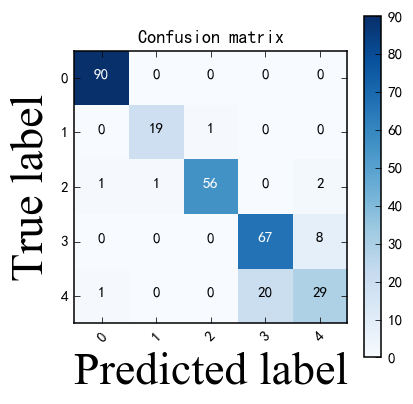

['0-喉', '1-上颚', '2-咽后壁', '3-右梨状窝', '4-左梨状窝']


In [23]:
K.set_learning_phase(0)
# model = trainer.load_model(50)
# 加载训练中的最优模型
use_increase = False
# 显示预测准确度、混淆矩阵，保持混淆矩阵图到root_path
acc, y_pred, y_true, file_test,_,_ = trainer.predict_data([r"E:\projects\znyx-trainer\job\口咽部\第2轮\训练集\imgs_valid"], model = model)

path = Plot.show_matrix(y_pred, y_true, types_num, root_path)
plt.show()
print(desc_list)

In [40]:
import time
pred_err_out = 1
def test_fold(to_chk_path, binary_threshold = 0.8):
    to_check_path_result = to_chk_path + '_result_' + time.strftime("%y%m%d_%H%M%S", time.localtime(time.time()))
    if not os.path.exists(to_check_path_result):
        os.makedirs(to_check_path_result)
        
    acc, y_pred, y_true, file_test, predicts,_ = trainer.predict_data([to_chk_path], model=model,
                                                                    binary_threshold=binary_threshold)

    if pred_err_out:
        # 输出预测错误图片到pred_err_path
        trainer.extract_files(file_test, y_pred, y_true, to_check_path_result)
    path = Plot.show_matrix(y_pred, y_true, types_num, to_check_path_result)
    if types_num == 2:
        Plot.get_roc(y_true, predicts, to_check_path_result)
    plt.show()
    print(desc_list)
    return y_pred

find 3 from E:\projects\znyx-trainer\job\HuaLu_FenLei/test
load data from fold finished ,count=176
176/176 [==============================] - 1s 3ms/step
cast626ms, fold: ['E:\\projects\\znyx-trainer\\job\\HuaLu_FenLei/test'] ,accurracy:94
extract 9 files to E:\projects\znyx-trainer\job\HuaLu_FenLei/test_result_210723_172213 finished


2021-07-23 17:22:20,993 - INFO - plot.py - show_matrix - 222 - save plot image to E:\projects\znyx-trainer\job\HuaLu_FenLei\test_result_210723_172213\2021-07-23-17-22_966.png 
2021-07-23 17:22:20,994 - INFO - plot.py - show_matrix - 238 - accurracy:0.9488636363636364


Confusion matrix, without normalization
[[57  0  0]
 [ 0 39  1]
 [ 2  6 71]]
00 acc: 100.00%
01 acc: 97.50%
02 acc: 89.87%
overall acc: 94.89%, avg acc: 95.79%


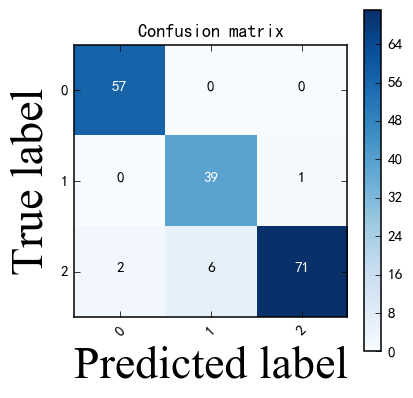

['0-非胃癌', '1-典型性管状腺癌', '2-典型性黏液腺癌']


In [41]:
y_pred = test_fold(test_path)